# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import cm

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

import dum_trans 
from dum_trans import GetDummies

import re

In [3]:
# define base color for plotting
base_color = sb.color_palette()[0]
# define color palette for plotting
viridis = cm.get_cmap('viridis', 16)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
azdias=azdias.drop('Unnamed: 0', axis=1)

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers=customers.drop('Unnamed: 0', axis=1)

### Population data

In [6]:
print (azdias.shape)
azdias.head(5)

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


There are 6 non numeric format columns. CAMEO_DEUG_2015 & CAMEO_INTL_2015 should be integer and EINGEFUEGT_AM - datetime

**Correct object columns**

In [8]:
azdias.select_dtypes(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


Columns 19 and 20 of azdias df gives error of mixed type when loading, as we removed 'Unnamed: 0'-column we have to look at cols 18 and 19. Let's see what values it contains

In [9]:
print (azdias[azdias.columns[17]].value_counts())

print (azdias[azdias.columns[18]].value_counts())
azdias[azdias.columns[19]].value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64
8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64


51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

There are 373 rows with X/XX value and numeric values are in wrong format

In [10]:
def correct_object_cols(data):
    '''function that corrects object columns: 
    1) removes X and XX from cols 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015'
    and change column format from str to float
    2) EINGEFUEGT_AM to datetime and extract year only
    3) OST_WEST_KZ is 1 if 'W' and 0 if 'O', change to float
    
    INTPUT: data - dataframe to be corrected
    OUTPUT: data - corrected dataframe
    '''
    # Replace XX and X with NaN
    data.loc[(data['CAMEO_DEUG_2015']=='X'), 'CAMEO_DEUG_2015']=np.nan
    data.loc[(data['CAMEO_INTL_2015']=='XX'), 'CAMEO_INTL_2015']=np.nan
    data.loc[(data['CAMEO_DEU_2015']=='XX'), 'CAMEO_DEU_2015']=np.nan
    
    # change string type to flaot
    data['CAMEO_DEUG_2015']=data['CAMEO_DEUG_2015'].astype(float)
    data['CAMEO_INTL_2015']=data['CAMEO_INTL_2015'].astype(float)
    
    #column EINGEFUEGT_AM to datetime format and take only year out
    data['EINGEFUEGT_AM']=pd.to_datetime(data['EINGEFUEGT_AM']).dt.year
    
    # OST_WEST_KZ column has values 'O' and 'W'
    data.loc[data['OST_WEST_KZ']=='O', 'OST_WEST_KZ']=0
    data.loc[data['OST_WEST_KZ']=='W', 'OST_WEST_KZ']=1
    data['OST_WEST_KZ']=data['OST_WEST_KZ'].astype(float)
    
    # year of birth should be a number not 0
    data.loc[data['GEBURTSJAHR']==0, 'GEBURTSJAHR']=np.nan
    return data

In [11]:
azdias=correct_object_cols(azdias)

Let's check the number of NaN values in dataframe 

In [12]:
azdias.isna().sum().sum()

33886360

**Feature description and it's value**

The DIAS Attributes - Values 2017.xlsx contains detailed mapping of data values for each feature in alphabetical order. We can search for all variations of 'unknown' values for each column from 'DIAS Attributes - Values 2017.xlsx'. The goal is to replace all numeric unknown values with NaN and find all incorect records in dataframe.

In [13]:
# read elsx file
feature_desc=pd.read_excel('DIAS Attributes - Values 2017_eks.xlsx',  header=1)
feature_desc.drop('Unnamed: 0', axis=1, inplace=True)
feature_desc.head(10)

,Attribute,Description,Value,Meaning,Type1,Type2
0,AGER_TYP,best-ager typology,-1,unknown,categorical,nominal
1,NaN,NaN,0,no classification possible,NaN,NaN
2,NaN,NaN,1,passive elderly,NaN,NaN
3,NaN,NaN,2,cultural elderly,NaN,NaN
4,NaN,NaN,3,experience-driven elderly,NaN,NaN
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,categorical,NaN
6,NaN,NaN,1,< 30 years,NaN,NaN
7,NaN,NaN,2,30 - 45 years,NaN,NaN
8,NaN,NaN,3,46 - 60 years,NaN,NaN
9,NaN,NaN,4,> 60 years,NaN,NaN


In [14]:
# if Attribute and Description and NaN fill it with values from row above 
for i in range(0, feature_desc.shape[0]):
    if feature_desc['Attribute'].isna()[i]:
        feature_desc.loc[i, 'Attribute'] = feature_desc.loc[i-1, 'Attribute']
        feature_desc.loc[i, 'Description'] = feature_desc.loc[i-1, 'Description']
        feature_desc.loc[i, 'Type1'] = feature_desc.loc[i-1, 'Type1']
        feature_desc.loc[i, 'Type2'] = feature_desc.loc[i-1, 'Type2']
        
# if values in Meaning is NaN fill it with the value from row above
for i in range(0, feature_desc.shape[0]):
    if feature_desc['Meaning'].isna()[i]:
        feature_desc.loc[i, 'Meaning'] = feature_desc.loc[i-1, 'Meaning']

In [15]:
# check number of columns that are in population df and in feature description
common_cols_population_features=np.intersect1d(np.array(azdias.columns), np.array(feature_desc['Attribute'].unique()), assume_unique=True)
len(common_cols_population_features)

271

In [16]:
# number of attributes in feature_desc df
len(feature_desc['Attribute'].unique())

314

In [17]:
# the columns of population df that don't have discription in feature_desc
no_feature_desc_cols=np.setdiff1d(np.array(azdias.columns), np.array(feature_desc['Attribute'].unique()), assume_unique=True)
len(no_feature_desc_cols)

95

In [18]:
# the features that don't present in columns of population df 
att_not_in_population=np.setdiff1d( np.array(feature_desc['Attribute'].unique()),np.array(azdias.columns), assume_unique=True)
att_not_in_population

array(["'MIN_GEBAEUDEJAHR'", 'BIP_FLAG', 'CAMEO_DEUINTL_2015',
       'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ',
       'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ',
       'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ',
       'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ',
       'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ',
       'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ',
       'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP',
       'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ',
       'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ',
       'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ',
       'D19_TECHNIK_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ',
       'D19_TIERARTIKEL_RZ', 'D19_VERSAND_REST_RZ',
       'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT_RZ',
       'D19_WEIN_FEINKOST_RZ', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR',
       'KBA13_CCM_1400_2500', 'SOHO_FLAG', 'WACHSTUMSGEBIET

In [19]:
# find columns in population df that starts with D19
azdias.columns[azdias.columns.str.contains(pat = 'D19')]

Index(['D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24

In [20]:
# it seems that difference is columns starting with D19 in _RZ ending, so we have to rename attributes 
for i in att_not_in_population:
    feature_desc.loc[feature_desc['Attribute']==i, 'Attribute']=feature_desc['Attribute'].str.replace(r'_RZ', '')
np.setdiff1d( np.array(feature_desc['Attribute'].unique()),np.array(azdias.columns), assume_unique=True)

# also change CAMEO_DEUINTL_2015 to CAMEO_INTL_2015
feature_desc.loc[feature_desc['Attribute']=='CAMEO_DEUINTL_2015', 'Attribute']='CAMEO_INTL_2015'

####
feature_desc.loc[feature_desc['Attribute']=='D19_BUCH', 'Attribute']='D19_BUCH_CD'
feature_desc.loc[feature_desc['Attribute']=='D19_KK_KUNDENTYP', 'Attribute']='KK_KUNDENTYP'
feature_desc.loc[feature_desc['Attribute']=='KBA13_CCM_1400_2500', 'Attribute']='KBA13_CCM_1401_2500'


In [21]:
# check number of columns that are in population df and in feature description
len(np.intersect1d(np.array(azdias.columns), np.array(feature_desc['Attribute'].unique()), assume_unique=True))

308

In [22]:
# cols that are in population df but not in feature_desc
no_feature_desc_cols=np.setdiff1d(np.array(azdias.columns), np.array(feature_desc['Attribute'].unique()), assume_unique=True)
print (len(no_feature_desc_cols))
no_feature_desc_cols

58


array(['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_DATUM',
       'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM',
       'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM',
       'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP',
       'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3',
       'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_HHZ',
       'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER',
       'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ',
       'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG',
       'VERDICHTUN

In [23]:
# columns that are in population df but not explained in features
att_not_in_population=np.setdiff1d(np.array(feature_desc['Attribute'].unique()), np.array(azdias.columns) )
att_not_in_population

array(["'MIN_GEBAEUDEJAHR'", 'BIP_FLAG', 'GEOSCORE_KLS7',
       'HAUSHALTSSTRUKTUR', 'SOHO_FLAG', 'WACHSTUMSGEBIET_NB'],
      dtype=object)

**Get all 'unknown' values from feature description file**

In [24]:
# Find all type of Meaning that contains 'known' 
feature_desc[feature_desc['Meaning'].str.contains('know')]['Meaning'].unique()

array(['unknown', 'unknown / no main age detectable',
       'no transactions known', 'no transaction known',
       'residental building buildings without actually known household',
       'mixed building without actually known household or comapny ',
       'company building w/o known company ',
       'mixed building without actually known household ',
       'mixed building without actually known company '], dtype=object)

In [25]:
# lets check if 'no transaction(s) known' is cetegory indicator or if there are more categories in the same attribute.

In [26]:
no_main_age_cols=feature_desc[feature_desc['Meaning']=='unknown / no main age detectable']['Attribute'].to_list()

In [27]:
no_trans_known_cols=feature_desc[(feature_desc['Meaning']=='no transaction known')|
                                 (feature_desc['Meaning']=='no transaction known')]['Attribute'].to_list()

In [28]:
feature_desc[feature_desc['Attribute'].isin(no_trans_known_cols)].head(20)

,Attribute,Description,Value,Meaning,Type1,Type2
162,D19_BANKEN_DIREKT,transactional activity based on the product gr...,0,no transaction known,categorical,NaN
163,D19_BANKEN_DIREKT,transactional activity based on the product gr...,1,Multibuyer 0-12 months,categorical,NaN
164,D19_BANKEN_DIREKT,transactional activity based on the product gr...,2,Doublebuyer 0-12 months,categorical,NaN
165,D19_BANKEN_DIREKT,transactional activity based on the product gr...,3,Singlebuyer 0-12 months,categorical,NaN
166,D19_BANKEN_DIREKT,transactional activity based on the product gr...,4,Multi-/Doublebuyer 13-24 months,categorical,NaN
167,D19_BANKEN_DIREKT,transactional activity based on the product gr...,5,Singlebuyer 13-24 months,categorical,NaN
168,D19_BANKEN_DIREKT,transactional activity based on the product gr...,6,Buyer > 24 months,categorical,NaN
169,D19_BANKEN_DIREKT,transactional activity based on the product gr...,7,Prospects > 24 months,categorical,NaN
170,D19_BANKEN_GROSS,transactional activity based on the product gr...,0,no transaction known,categorical,NaN
171,D19_BANKEN_GROSS,transactional activity based on the product gr...,1,Multibuyer 0-12 months,categorical,NaN


In [29]:
# get subset with unknown values only:
# 'unknown', 'unknown / no main age detectable',
# 'no transactions known', 'no transaction known',

feature_unknown=feature_desc[feature_desc['Meaning'].str.contains('unknow')].reset_index(drop=True)
feature_unknown=feature_unknown.append(feature_desc[feature_desc['Meaning']=='no transactions known'])
feature_unknown=feature_unknown.append(feature_desc[feature_desc['Meaning']=='no transaction known'])
feature_unknown=feature_unknown.reset_index(drop=True)
feature_unknown['Value'].value_counts()

-1       138
-1, 9     75
0         47
-1, 0     16
10        12
-1         1
Name: Value, dtype: int64

In [30]:
# For some columns of azdias dataframe there is two possibilities for unknown value, 
# we will need to assess both of the value 
feature_unknown['unknown']=feature_unknown['Value'].str.split(', ')
feature_unknown.loc[feature_unknown['unknown'].isna(), 'unknown']=feature_unknown.loc[feature_unknown['unknown'].isna(), 'Value']
feature_unknown

,Attribute,Description,Value,Meaning,Type1,Type2,unknown
0,AGER_TYP,best-ager typology,-1,unknown,categorical,nominal,-1
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,categorical,NaN,"[-1, 0]"
2,ALTER_HH,main age within the household,0,unknown / no main age detectable,categorical,NaN,0
3,ANREDE_KZ,gender,"-1, 0",unknown,binary,NaN,"[-1, 0]"
4,BALLRAUM,distance to next urban centre,-1,unknown,NaN,NaN,-1
...,...,...,...,...,...,...,...
284,D19_TIERARTIKEL,transactional activity based on the product gr...,0,no transaction known,categorical,NaN,0
285,D19_VERSAND_REST,transactional activity based on the product gr...,0,no transaction known,categorical,NaN,0
286,D19_VERSICHERUNGEN,transactional activity based on the product gr...,0,no transaction known,categorical,NaN,0
287,D19_VOLLSORTIMENT,transactional activity based on the product gr...,0,no transaction known,categorical,NaN,0


In [31]:
# go through all values in features_unknown dataframe and replace string with int
for i in range(0,feature_unknown.shape[0]):
    # if it's a set of two string values (['-1', '9']) replace it with integer
    if not isinstance(feature_unknown['unknown'].iloc[i], int):
        for item in range(len(feature_unknown.loc[i,'unknown'])):
            try:
                feature_unknown.loc[i,'unknown'][item] = int(feature_unknown.loc[i,'unknown'][item])
            except:
                continue


In [32]:
def unknown_replace(data, feature_unknown):
    '''replace all unknown values with NaNs
    
    INPUT: 
    data - users/customers dataframe
    feature_unknown -  detailed mapping of unknown data values for each feature.
    
    OUTPUT: data with replaced unknown values
    '''
    for i in range(0,feature_unknown.shape[0]):
        # while going through all columns names replace unknown values with NaN
        if feature_unknown.loc[i, 'Attribute'] in data.columns:
            data.loc[:,(feature_unknown.loc[i, 'Attribute'])].replace(feature_unknown.loc[i,'unknown'], np.nan, inplace=True) 
    
    return data

In [33]:
# replace unknown values
azdias=unknown_replace(azdias,feature_unknown)

In [34]:
azdias.isna().sum().sum()

77930703

**Check if data in population is in correct range of values as per features_desc**

In [35]:
def check_values(data, feature_desc):
    '''Function goes through all common int and float columns in dataframe and feature description file, 
    compares the set of values seen in dataframe for each feature 
    and possible values that are indicated in feature description
    
    Prints information of the columns of df that has additional values (not met in feature description)
    
    INPUT: 
    data  - dataframe 
    feature_desc - df with description of features'''
    
    # find common columns
    common_cols=np.intersect1d(np.array(data.columns), np.array(feature_desc['Attribute'].unique()), assume_unique=True)
    
    for i in common_cols:
        # column of int or float type
        if (data[i].dtypes=='float64') or (data[i].dtypes=='int64'):
            # list of values that present in population df
            a=list(map(int,list(data[i].value_counts().index)))
            # list of values that is in feature description
            b=(list(feature_desc[feature_desc['Attribute']==i]['Value'].values))
        
            if (len(np.intersect1d(a,b))!=len(a)) and (b!=['…']):
                # print cases when there are additional values in population df
                print ('Column name: ', i)
                print ('Values in population df: ',a)
                print ('Values in feature description: ',b)

In [36]:
check_values(azdias, feature_desc)

Column name:  KBA05_MODTEMP
Values in population df:  [3, 4, 1, 2, 5, 6]
Values in feature description:  ['-1, 9', 1, 2, 3, 4, 5]
Column name:  LP_FAMILIE_FEIN
Values in population df:  [1, 10, 2, 0, 11, 8, 7, 4, 5, 9, 6, 3]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Column name:  LP_FAMILIE_GROB
Values in population df:  [1, 5, 2, 0, 4, 3]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Column name:  LP_LEBENSPHASE_FEIN
Values in population df:  [0, 1, 5, 6, 2, 8, 11, 29, 7, 13, 10, 31, 12, 30, 15, 3, 19, 37, 4, 14, 20, 32, 39, 40, 27, 16, 38, 35, 34, 9, 21, 28, 24, 36, 25, 23, 22, 18, 33, 17, 26]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Column name:  LP_LEBENSPHASE_GROB
Values in population df:  [2, 1, 3, 0, 12, 4, 5, 9, 10, 11, 8, 6, 7]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10

In [37]:
def replace_incorrect_values(data):
    # replace all values that didn't corresponds to allowed values in the columns
    data.loc[data['KBA05_MODTEMP']==6, 'KBA05_MODTEMP']=np.nan
    data.loc[data['LP_FAMILIE_FEIN']==0, 'LP_FAMILIE_FEIN']=np.nan
    data.loc[data['LP_FAMILIE_GROB']==0, 'LP_FAMILIE_GROB']=np.nan
    data.loc[data['LP_LEBENSPHASE_FEIN']==0, 'LP_LEBENSPHASE_FEIN']=np.nan
    data.loc[data['LP_LEBENSPHASE_GROB']==0, 'LP_LEBENSPHASE_GROB']=np.nan
    data.loc[data['ORTSGR_KLS9']==0, 'KBA05_MODTEMP']=np.nan
    return data

In [38]:
azdias=replace_incorrect_values(azdias)

In [39]:
# number of NaNs is population dataframe after replacement 
azdias.isna().sum().sum()

78268628

**Visualise ammount of missing values per columns**

In [40]:
def plot_top_n_feature(data, n):
    '''Calculate percentages of missing values per column and order it,
    Plot n top features and percentage of missing data'''
    
    # calculate percentages of missing values per column and order it
    data1=data.isna().sum().sort_values(ascending=False)/data.shape[0]
    
    plt.figure(figsize=[15, 5])
    sb.barplot(data1.index[:n], data1.values[:n], color=base_color)
    plt.xticks(rotation=90);
    plt.ylabel('Percentage of missing data');
    return data1

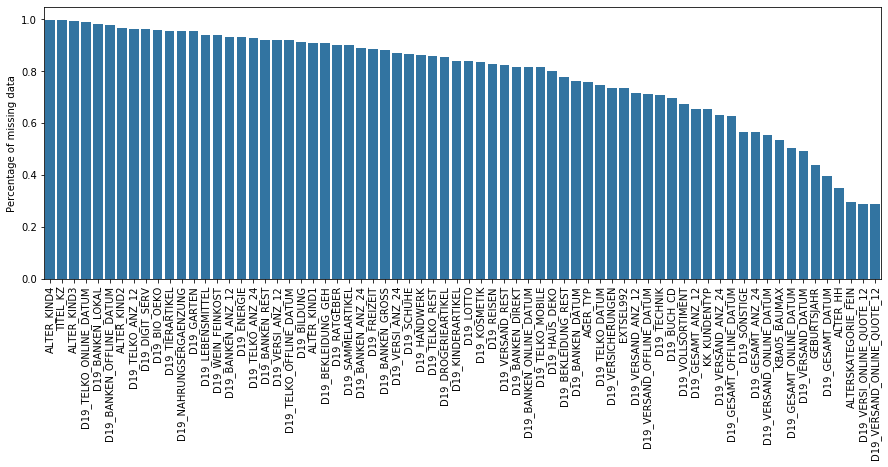

In [41]:
# plot top 70 columns with maximum missing values
perc_NaNs_cols_azdias=plot_top_n_feature(azdias, 70)

In [42]:
# tere are lots of columns that miss more than 30 % of data
print ('{} columns miss more than 30% of data '.format(len(perc_NaNs_cols_azdias[perc_NaNs_cols_azdias>0.3])))

67 columns miss more than 30% of data 


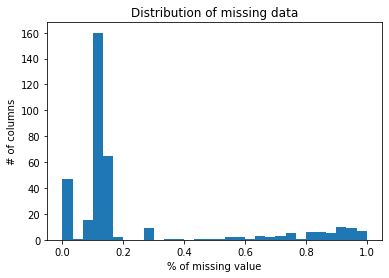

In [43]:
# plot distribution of missing data
plt.hist(perc_NaNs_cols_azdias.values, bins = 30);
plt.xlabel('% of missing value')
plt.ylabel('# of columns')
plt.title('Distribution of missing data');

I will remove all columns with more that 30% of missing data 

ALTER_KIND4                   0.998648
ALTER_KIND3                   0.993077
ALTER_KIND2                   0.966900
ALTER_KIND1                   0.909048
EXTSEL992                     0.733996
ALTERSKATEGORIE_FEIN          0.295041
D19_SOZIALES                  0.288495
D19_LETZTER_KAUF_BRANCHE      0.288495
D19_VERSI_ONLINE_QUOTE_12     0.288495
D19_TELKO_ONLINE_QUOTE_12     0.288495
VHN                           0.135989
HH_DELTA_FLAG                 0.120735
KBA13_ANTG1                   0.118714
KBA13_HHZ                     0.118714
KBA13_ANTG3                   0.118714
KBA13_ANTG4                   0.118714
KBA13_BAUMAX                  0.118714
KBA13_ANTG2                   0.118714
KBA13_GBZ                     0.118714
KBA13_KMH_210                 0.118714
UMFELD_ALT                    0.109721
UMFELD_JUNG                   0.109721
GEMEINDETYP                   0.109147
VERDICHTUNGSRAUM              0.109147
STRUKTURTYP                   0.109147
ARBEIT                   

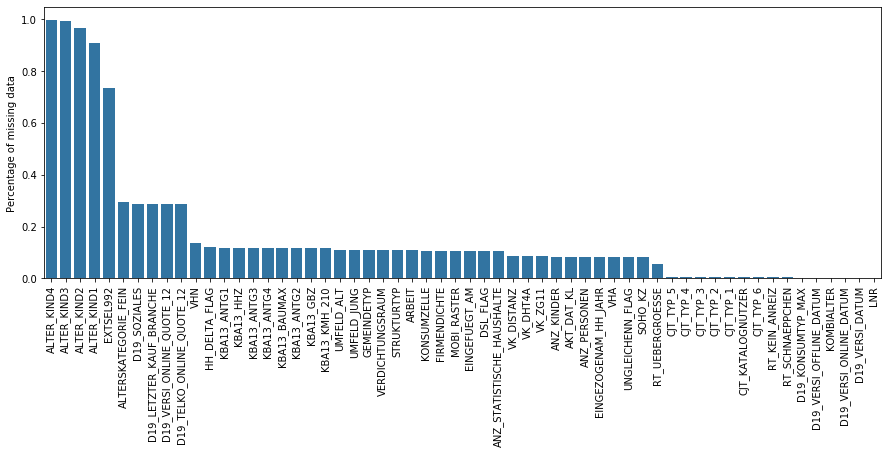

In [44]:
# plot missing values in columns that were not explained in feature_desc
plot_top_n_feature(azdias[list(no_feature_desc_cols)], azdias[list(no_feature_desc_cols)].shape[1])

In [45]:
# find columns to remove
# all column where percentage of missing values more than 30 % will be removed
df1=pd.DataFrame(perc_NaNs_cols_azdias).rename(columns={0:'percentage'})
cols_to_remove=list(df1[df1['percentage']>0.3].index)

In [46]:
# remove columns from df
azdias=azdias.drop(cols_to_remove, axis=1)

In [47]:
# columns that has to be removed as having to many categories (excl 'CAMEO_INT_2015')
cols_to_remove2=[]
for i in azdias.columns:
    if len(azdias[i].value_counts())>10:
        cols_to_remove2.append(str(i))



In [48]:
cols_to_remove2=['LNR',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'CAMEO_DEU_2015',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'VERDICHTUNGSRAUM',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11']
len(cols_to_remove2)

17

In [49]:
# remove columns from df
azdias=azdias.drop(cols_to_remove2, axis=1)

In [50]:
# columns that are in population df but not explained in features
cols_pop_no_feature_desc=np.setdiff1d(np.array(azdias.columns), np.array(feature_desc['Attribute'].unique()))

In [51]:
# go through all columns that sre in population df but not explained in features and look for class imbalance
for i in cols_pop_no_feature_desc:
    print (azdias[i].value_counts())
    print (len(azdias[i].value_counts()))

1.0    390258
9.0    270663
5.0     29203
6.0     27655
3.0     24880
4.0     21466
7.0     21026
8.0     17485
2.0     15086
Name: AKT_DAT_KL, dtype: int64
9
1.0     423383
2.0     195470
3.0      94905
4.0      47126
0.0      34103
5.0      15503
6.0       4842
7.0       1525
8.0        523
9.0        180
10.0        67
11.0        38
12.0        16
13.0        11
21.0         4
14.0         4
20.0         3
15.0         3
38.0         2
23.0         2
37.0         2
22.0         2
35.0         1
17.0         1
16.0         1
45.0         1
18.0         1
40.0         1
29.0         1
31.0         1
Name: ANZ_PERSONEN, dtype: int64
30
1.0      219119
2.0      121485
3.0       61478
4.0       44864
5.0       40133
          ...  
190.0         2
336.0         2
197.0         2
133.0         1
314.0         1
Name: ANZ_STATISTISCHE_HAUSHALTE, Length: 268, dtype: int64
268
4.0    311339
3.0    254988
2.0    135662
1.0     56767
5.0     35090
9.0       159
Name: ARBEIT, dtype: int64
6
5.

In [52]:
# columns description of which is not in feature_desc and with very high ammount of )/10 values
cols_to_remove3=['D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
                 'D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM',
                'VHA',  'ANZ_TITEL']
# remove columns from df
azdias=azdias.drop(cols_to_remove3, axis=1)

In [53]:
# all columns that we been removed 
cols_to_remove=cols_to_remove+cols_to_remove2+cols_to_remove3

In [54]:
azdias.shape

(891221, 274)

**Feature engineering**

In [55]:
def engineer_CAMEO_INTL_2015(data):
    #create new ordinal attribute WEALTH
    data['CAMEO_INTL_2015_WEALTH'] =(data['CAMEO_INTL_2015']/10).apply(np.floor)


    #create new ordinal attribute FAMILY_STATUS
    data['CAMEO_INTL_2015_FAM_STAT'] =data['CAMEO_INTL_2015']-10*(data['CAMEO_INTL_2015']/10).apply(np.floor)
    data=data.drop('CAMEO_INTL_2015', axis=1)
    return data

In [56]:
azdias=engineer_CAMEO_INTL_2015(azdias)

In [57]:
# do we want to engineer new features here?
azdias['WOHNLAGE'].value_counts()

3.0    249719
7.0    169318
4.0    135973
2.0    100376
5.0     74346
1.0     43918
8.0     17473
0.0      6950
Name: WOHNLAGE, dtype: int64

In [58]:
azdias.shape

(891221, 275)

**Visualize ammount of missing data per row**

In [59]:
azdias['NaN_in_row']=azdias.isna().sum(axis=1)

In [60]:
# num of columns with more than 30 missing elements in row
(azdias['NaN_in_row']>30).sum()

153934

In [61]:
print ("There are {} rows of total {} with more than 30 of missing data points".format((azdias['NaN_in_row']>30).sum(), azdias.shape[0]))

There are 153934 rows of total 891221 with more than 30 of missing data points


In [62]:
# num of columns with more than 30 missing elements in row
(azdias['NaN_in_row']<30).sum()

737287

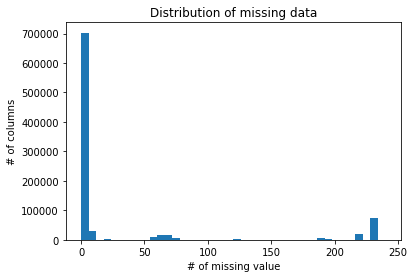

In [63]:
# plot distribution of missing data
plt.hist(azdias['NaN_in_row'], bins = 40);
plt.xlabel('# of missing value')
plt.ylabel('# of columns')
plt.title('Distribution of missing data');

In [64]:
# split data in two datasets with more than 30 missing elements per row and less than 30.
azdias_many=azdias[azdias['NaN_in_row']>=30]
azdias_many=azdias_many.drop('NaN_in_row', axis=1)
azdias_few=azdias[azdias['NaN_in_row']<30]
azdias_few=azdias_few.drop('NaN_in_row', axis=1)
azdias=azdias.drop('NaN_in_row', axis=1)

In [65]:
#let's check distribution of few columns with almost no missing values for each of this groups 
azdias.isna().sum().sort_values(ascending=True).head(30)

FINANZ_SPARER               0
FINANZ_UNAUFFAELLIGER       0
FINANZ_VORSORGER            0
FINANZTYP                   0
SEMIO_DOM                   0
SEMIO_ERL                   0
SEMIO_FAM                   0
SEMIO_KAEM                  0
GREEN_AVANTGARDE            0
SEMIO_TRADV                 0
ZABEOTYP                    0
SEMIO_KULT                  0
SEMIO_LUST                  0
KOMBIALTER                  0
SEMIO_MAT                   0
SEMIO_PFLICHT               0
SEMIO_RAT                   0
SEMIO_REL                   0
SEMIO_VERT                  0
SEMIO_KRIT                  0
FINANZ_MINIMALIST           0
SEMIO_SOZ                   0
FINANZ_ANLEGER              0
D19_KONSUMTYP_MAX           0
ANREDE_KZ                   0
ALTERSKATEGORIE_GROB        0
FINANZ_HAUSBAUER            0
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
ONLINE_AFFINITAET        4854
dtype: int64

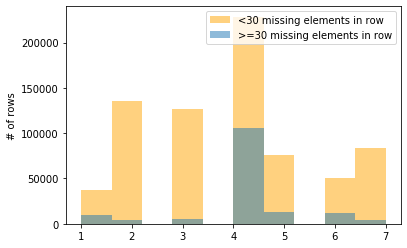

In [66]:
col_name='SEMIO_RAT'
plt.hist(azdias_few[col_name], color='orange', alpha=0.5, label='<30 missing elements in row')
plt.hist(azdias_many[col_name], color=base_color, alpha=0.5, label='>=30 missing elements in row')
plt.ylabel('# of rows');
plt.legend();

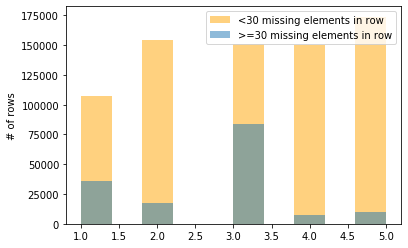

In [67]:
col_name='FINANZ_HAUSBAUER'
plt.hist(azdias_few[col_name], color='orange', alpha=0.5, label='<30 missing elements in row')
plt.hist(azdias_many[col_name], color=base_color, alpha=0.5, label='>=30 missing elements in row')
plt.ylabel('# of rows');
plt.legend();

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


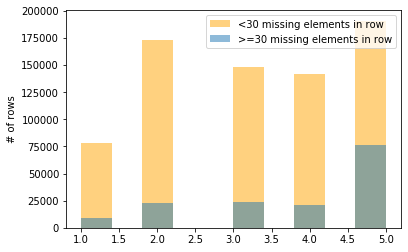

In [68]:
col_name='CJT_TYP_1'
plt.hist(azdias_few[col_name], color='orange', alpha=0.5, label='<30 missing elements in row')
plt.hist(azdias_many[col_name], color=base_color, alpha=0.5, label='>=30 missing elements in row')
plt.ylabel('# of rows');
plt.legend();

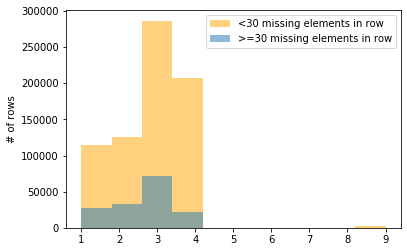

In [69]:
col_name='ALTERSKATEGORIE_GROB'
plt.hist(azdias_few[col_name], color='orange', alpha=0.5, label='<30 missing elements in row')
plt.hist(azdias_many[col_name], color=base_color, alpha=0.5, label='>=30 missing elements in row')
plt.ylabel('# of rows');
plt.legend();

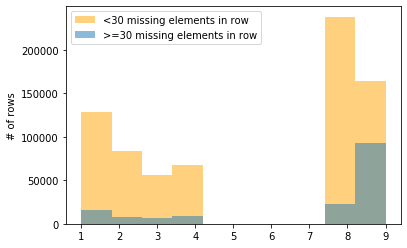

In [70]:
col_name='D19_KONSUMTYP_MAX'
plt.hist(azdias_few[col_name], color='orange', alpha=0.5, label='<30 missing elements in row')
plt.hist(azdias_many[col_name], color=base_color, alpha=0.5, label='>=30 missing elements in row')
plt.ylabel('# of rows');
plt.legend();

### Columns transformation per type

In [71]:
feature_type=feature_desc[['Attribute', 'Type1', 'Type2']].drop_duplicates().reset_index(drop=True)

In [72]:
feature_type['Type']=feature_type['Type1']+feature_type['Type2']
feature_type.loc[feature_type['Type2'].isna(), 'Type']=feature_type['Type1']

feature_type['Type']=feature_type['Type'].replace(['categorical ','categoricalnominal' , 'categoricalnominal?'], 
                             ['categorical', 'categorical nominal', 'categorical nominal?'])

In [73]:
len(np.intersect1d(azdias.columns, feature_type['Attribute']))

237

In [74]:
len(np.setdiff1d(azdias.columns, feature_type['Attribute']))

38

In [75]:
nominal_cols=list(feature_type[feature_type['Type']=='categorical nominal']['Attribute'])
nominal_cols=list(np.intersect1d(nominal_cols, azdias.columns))
print ('Nominal columns: ', nominal_cols, '\n')

nominal_cols_q=list(feature_type[feature_type['Type']=='categorical nominal?']['Attribute'])
nominal_cols_q=list(np.intersect1d(nominal_cols_q, azdias.columns))
print ('Nominal columns?: ', nominal_cols_q, '\n')

binary_cols=list(feature_type[feature_type['Type']=='binary']['Attribute'])
binary_cols=list(np.intersect1d(binary_cols, azdias.columns))
print ('Binary columns: ', binary_cols, '\n')

numeric_cols=list(feature_type[feature_type['Type']=='numeric']['Attribute'])
numeric_cols=list(np.intersect1d(numeric_cols, azdias.columns))
print ('Numeric columns: ', numeric_cols, '\n')

mixed_cols=list(feature_type[feature_type['Type']=='mixed_categorical']['Attribute'])
mixed_cols=list(np.intersect1d(mixed_cols, azdias.columns))
print ('Mixed categorical columns: ', mixed_cols, '\n')

ordinal_categorical_cols=list(feature_type[feature_type['Type']=='categorical']['Attribute'])
ordinal_categorical_cols=list(np.intersect1d(ordinal_categorical_cols, azdias.columns))
print ('Ordinal categorical columns: ', ordinal_categorical_cols, '\n')

define_type=list(np.setdiff1d(azdias.columns, feature_type['Attribute']))
print ('columns which type shall be defined: ', define_type)

Nominal columns:  ['CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_MAXHERST', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP'] 

Nominal columns?:  ['REGIOTYP', 'RETOURTYP_BK_S'] 

Binary columns:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'KBA05_SEG6', 'OST_WEST_KZ', 'VERS_TYP'] 

Numeric columns:  ['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'] 

Mixed categorical columns:  ['GEBAEUDETYP_RASTER', 'LP_LEBENSPHASE_FEIN', 'WOHNLAGE'] 

Ordinal categorical columns:  ['ALTERSKATEGORIE_GROB', 'CAMEO_DEUG_2015', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_CCM1', 'KBA05_CCM2'

In [76]:
for i in define_type:
    print (azdias[i].value_counts())

1.0    390258
9.0    270663
5.0     29203
6.0     27655
3.0     24880
4.0     21466
7.0     21026
8.0     17485
2.0     15086
Name: AKT_DAT_KL, dtype: int64
1.0     423383
2.0     195470
3.0      94905
4.0      47126
0.0      34103
5.0      15503
6.0       4842
7.0       1525
8.0        523
9.0        180
10.0        67
11.0        38
12.0        16
13.0        11
21.0         4
14.0         4
20.0         3
15.0         3
38.0         2
23.0         2
37.0         2
22.0         2
35.0         1
17.0         1
16.0         1
45.0         1
18.0         1
40.0         1
29.0         1
31.0         1
Name: ANZ_PERSONEN, dtype: int64
1.0      219119
2.0      121485
3.0       61478
4.0       44864
5.0       40133
          ...  
190.0         2
336.0         2
197.0         2
133.0         1
314.0         1
Name: ANZ_STATISTISCHE_HAUSHALTE, Length: 268, dtype: int64
4.0    311339
3.0    254988
2.0    135662
1.0     56767
5.0     35090
9.0       159
Name: ARBEIT, dtype: int64
1.0    245054

In [77]:
binary_cols_extra=['DSL_FLAG', 'HH_DELTA_FLAG','KONSUMZELLE', 'SOHO_KZ', 'UNGLEICHENN_FLAG' ]
ordinal_categorical_cols_extra=list(np.setdiff1d(define_type, binary_cols_extra))

binary_cols=binary_cols+binary_cols_extra
ordinal_categorical_cols=ordinal_categorical_cols+ordinal_categorical_cols_extra

nominal_cols=nominal_cols+[ 'CAMEO_INTL_2015_FAM_STAT'] #'CAMEO_INTL_2015_WEALTH',

In [78]:
log_transform_cols=[]
for i in numeric_cols:
    if azdias[i].skew()>1:
        log_transform_cols.append(i)
numeric_cols=list(np.setdiff1d(numeric_cols, log_transform_cols))

In [79]:
log_transform_cols

['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']

log_transform_cols:
- impute with median
- log transform
- standard scaler

numeric_cols (normally distributed)+ ordinal_categorical_cols:

- impute with median
- standard scaler

binary_cols:
- impute with most frequent

nominal_cols + nominal_cols_q + mixed_cols:
- impute with -1 (columns with -1 should be deleted after transformation)
- One Hot encoding

In [80]:
import process
from process import GetDummies

log_transformer =  Pipeline([
    ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log_transform', FunctionTransformer(func = np.log1p, inverse_func=np.expm1, validate=False)), 
    ('log_scale', StandardScaler())
    ])

numeric_transformer=Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
    ])

binary_transformer=Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ])

# impute NaNs with -1 and than do One Hot Encoding, 
# however this way we get extra column for -1 values, that should be deleted, but how? 

nominal_transformer=Pipeline([
    ('encoder', process.GetDummies()),    
    ])

nominal_cols1=nominal_cols #+['WOHNLAGE']

preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_transform_cols),
        ('num', numeric_transformer, ordinal_categorical_cols),
        ('bin', binary_transformer, binary_cols),
        ('cat', nominal_transformer, nominal_cols1)
    ])   

In [81]:
preprocessor.fit(azdias_few)
azdias_transformed = preprocessor.transform(azdias_few)
azdias_transformed.shape

(737287, 350)

In [82]:
#obtain dummies column names
pl = preprocessor.named_transformers_['cat']
cd = pl.named_steps['encoder']
dummies_names = list(cd.get_feature_names())

In [83]:
col_names=log_transform_cols+ ordinal_categorical_cols+binary_cols+dummies_names
#col_names=dummies_names
len(col_names)

350

In [84]:
azdias_transformed=pd.DataFrame(azdias_transformed, columns = col_names)

azdias_transformed.head()

,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,ALTERSKATEGORIE_GROB,CAMEO_DEUG_2015,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_INTL_2015_FAM_STAT_1,CAMEO_INTL_2015_FAM_STAT_2,CAMEO_INTL_2015_FAM_STAT_3,CAMEO_INTL_2015_FAM_STAT_4,CAMEO_INTL_2015_FAM_STAT_5
0,0.847204,1.044696,-0.389348,-1.682096,0.979671,-0.562428,1.456800,1.321432,-1.476302,1.525204,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.751147,0.510558,-0.389348,0.168026,-0.631280,0.022249,-0.576719,1.321432,-1.476302,0.855782,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.130820,0.196099,2.359155,1.093087,-1.436756,-1.147104,-0.576719,-0.850074,0.695205,-0.483063,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.365616,-0.360468,-0.389348,0.168026,0.174196,0.606925,-1.254559,-0.850074,0.695205,0.186359,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.082000,1.575624,-0.389348,-1.682096,0.979671,-1.147104,-0.576719,1.321432,-0.028631,-1.152485,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA to reduce dimensionality

In [85]:
# Apply PCA 
pca = PCA()

azdias_pca = pca.fit_transform(azdias_transformed)

In [86]:
def pca_var(pca):
    num_components = len(pca.explained_variance_ratio_)
    component_idx = np.arange(num_components)
    pca_values = pca.explained_variance_ratio_

    plt.figure(figsize=(15, 10))
    ax = plt.subplot(211)
    pca_cum = np.cumsum(pca_values)
    ax.bar(component_idx, pca_values)
    ax.plot(component_idx, pca_cum)

    ax.xaxis.set_tick_params(width=1)
    ax.yaxis.set_tick_params(width=1, length=20)
    print ('Number of components: ', num_components)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance")
    plt.title('Variance VS Principal Component')

Number of components:  350


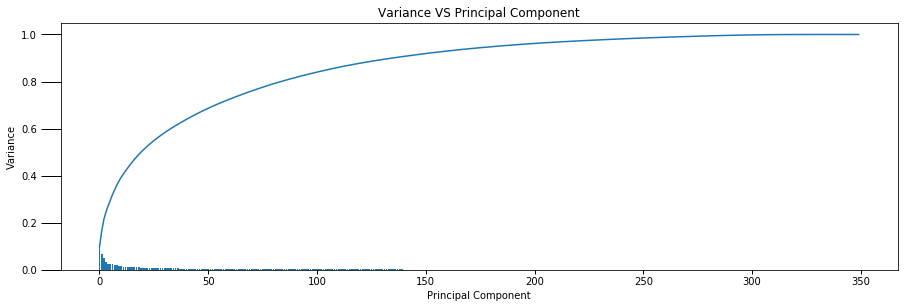

In [87]:
pca_var(pca)

In [88]:
n_components=200
round(sum(pca.explained_variance_ratio_[:n_components])*100, 2)

96.14

In [89]:
#PCA on 200 components
pca = PCA(n_components=200)

azdias_pca200 = pca.fit_transform(azdias_transformed)

Number of components:  200


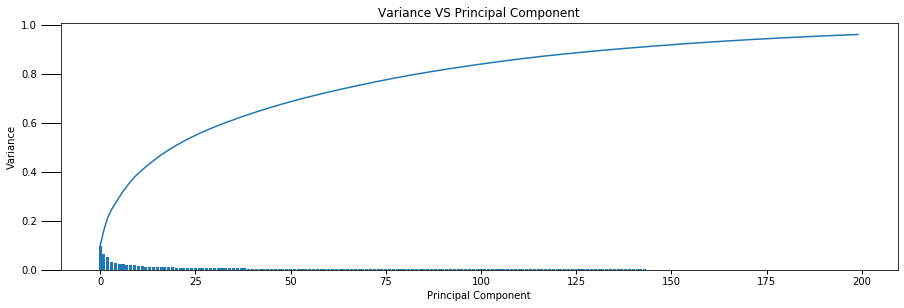

In [90]:
pca_var(pca)

In [91]:
# Map weights to principal components
def pca_feature_weights(df,pca, principal_comp):
    mapped_weights = []
    for num, feature in enumerate(azdias_transformed.columns):
        mapped_weights.append([feature, pca.components_[principal_comp][num]])
    
    return pd.DataFrame(mapped_weights).sort_values(1, ascending=False)

In [92]:
# Map weights for the first principal component to corresponding feature names
weights_1 = pca_feature_weights(azdias_transformed,pca,1)
weights_1

,0,1
119,KBA13_HERST_BMW_BENZ,0.189761
166,KBA13_SEG_OBEREMITTELKLASSE,0.162778
152,KBA13_MERCEDES,0.161098
88,KBA13_BMW,0.159330
173,KBA13_SITZE_4,0.148315
...,...,...
107,KBA13_HALTER_25,-0.120597
127,KBA13_KMH_180,-0.125811
161,KBA13_SEG_KLEINWAGEN,-0.136803
126,KBA13_KMH_140_210,-0.137857


In [93]:
weights_2 = pca_feature_weights(azdias_transformed,pca,2)
weights_2

,0,1
11,FINANZ_VORSORGER,0.207975
223,CJT_TYP_5,0.206531
3,ALTERSKATEGORIE_GROB,0.206044
222,CJT_TYP_4,0.194491
221,CJT_TYP_3,0.192252
...,...,...
10,FINANZ_UNAUFFAELLIGER,-0.197525
204,SEMIO_PFLICHT,-0.203004
220,CJT_TYP_2,-0.219202
9,FINANZ_SPARER,-0.221721


In [94]:
weights_3 = pca_feature_weights(azdias_transformed,pca,3)
weights_3

,0,1
147,KBA13_KW_61_120,0.189826
235,KBA13_KMH_210,0.174494
93,KBA13_CCM_1401_2500,0.159629
177,KBA13_VORB_0,0.150810
174,KBA13_SITZE_5,0.149617
...,...,...
123,KBA13_KMH_0_140,-0.150656
89,KBA13_CCM_0_1400,-0.152331
125,KBA13_KMH_140,-0.163474
83,KBA13_BJ_2000,-0.175602


### Clustering

In [95]:
scores = []
# try different number of clusters
batch_size=40000
centers = list(range(1,31))
for center in centers:
    
    # run MiniBatchKMeans clustering on the data
    kmeans = MiniBatchKMeans(n_clusters=center, batch_size=batch_size, random_state=42)
    model = kmeans.fit(azdias_pca200)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca200))
    scores.append(score)

In [96]:
scores

[181872695.4649644,
 168161919.72400704,
 163023991.26849437,
 159833839.48071143,
 157469724.46903273,
 155306698.66870674,
 152959135.86418295,
 151867077.2608454,
 149746059.7219042,
 149015858.44208568,
 148171682.88597837,
 147834682.65950087,
 147073311.81483608,
 145879240.3327618,
 145364078.97962242,
 144675947.41265306,
 144749489.7496843,
 143641117.2045175,
 143742692.4910143,
 143128142.9955045,
 142534443.7260367,
 142182712.63928285,
 141627746.52586207,
 141333535.26624048,
 140968196.24457514,
 141192926.96777463,
 140461516.78625578,
 140637111.6722427,
 140295206.98732522,
 139863475.67184517]

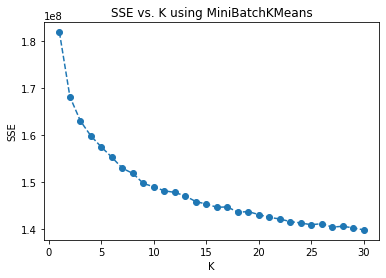

In [97]:
plt.plot(centers, scores, linestyle='--', marker='o', color=base_color);
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K using MiniBatchKMeans');

Take only 16 clusters, because after 16 decrease is slow

### KMean

In [98]:
n_components = 200
n_clusters = 16
cluster_pipeline = Pipeline([
                        ('transform', preprocessor), 
                        ('pca', PCA(n_components)),
                        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42) )
                        ])

In [99]:
cluster_pipeline.fit(azdias_few)

Pipeline(memory=None,
         steps=[('transform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('log',
                                                  Pipeline(memory=None,
                                                           steps=[('log_impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [100]:
pred_population= cluster_pipeline.predict(azdias_few)
pred_population[:20]

array([ 4,  3,  6,  7, 12,  3,  7,  9,  9, 11, 15,  3,  9,  4,  4, 15, 13,
        6,  8,  1])

In [101]:
len(pred_population)

737287

### Customers data

In [102]:
print (customers.shape)
customers.head(5)

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [103]:
# check if colums of customers and azdias dataframes are the same
# find number of common columns
np.intersect1d(azdias.columns.values, customers.columns.values).shape[0]

273

In [104]:
# unique columns for customers dataframe
col_unique_customers=np.setdiff1d(customers.columns.values, azdias.columns.values)
customers[col_unique_customers].head()

,AGER_TYP,ALTERSKATEGORIE_FEIN,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_HH_TITEL,ANZ_KINDER,ANZ_TITEL,...,LP_LEBENSPHASE_GROB,ONLINE_PURCHASE,PRAEGENDE_JUGENDJAHRE,PRODUCT_GROUP,TITEL_KZ,VERDICHTUNGSRAUM,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11
0,2,10.0,10.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,5.0,0,4,COSMETIC_AND_FOOD,0.0,8.0,0.0,5.0,3.0,2.0
1,-1,NaN,11.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0,0,FOOD,0.0,NaN,0.0,6.0,6.0,3.0
2,-1,0.0,6.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,3.0,0,4,COSMETIC_AND_FOOD,0.0,0.0,0.0,10.0,13.0,11.0
3,1,8.0,8.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0,1,COSMETIC,0.0,0.0,0.0,6.0,4.0,2.0
4,-1,14.0,20.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,10.0,0,8,FOOD,0.0,1.0,0.0,3.0,5.0,4.0


In [105]:
# check if there are missing values in this columns
customers[col_unique_customers].isna().sum()

AGER_TYP                     0
ALTERSKATEGORIE_FEIN     51842
ALTER_HH                 46596
ALTER_KIND1             179886
ALTER_KIND2             186552
                         ...  
VERDICHTUNGSRAUM         50476
VHA                      46596
VK_DHT4A                 47871
VK_DISTANZ               47871
VK_ZG11                  47871
Length: 96, dtype: int64

With all other columns (366) we need to replace all unknown values with NaNs as we did in population data

In [106]:
customers.isna().sum().sum()

13864522

In [107]:
def clean_data(data, feature_unknown, feature_desc, cols_to_remove, remove_rows=False):
    original_columns=data.columns
    # correct object columns
    data=correct_object_cols(data)
    # replace unknown values
    data=unknown_replace(data,feature_unknown)
    print ('Unknown values replaced with NaN')
    
    # replace all wrong entities in customers df
    check_values(data, feature_desc)
    data=replace_incorrect_values(data)
    print ('Incorrect values replaced with NaN')
    
    # drop columns
    data=data.drop(cols_to_remove, axis=1)
    print ('Columns droped')
    
    # engineer features
    data=engineer_CAMEO_INTL_2015(data)
    print ('New features are engineered')
    
    if remove_rows==True:
        print ('Rows with more that 30 elements removed')
        # drop if more than 30 missing attributes in row
        data['NaN_in_row']=data.isna().sum(axis=1)
        data_many=data[data['NaN_in_row']>=30]
        data_many=data_many.drop('NaN_in_row', axis=1)
        data_few=data[data['NaN_in_row']<30]
        data_few=data_few.drop('NaN_in_row', axis=1)
        data=data.drop('NaN_in_row', axis=1)

    else:
        print ('All rows are kept')
        data_few=data
        
    
    return data_few, data, original_columns 

  

In [108]:
customers_few, customers, original_columns_customers=clean_data(customers, feature_unknown, feature_desc, cols_to_remove, remove_rows=True)
# drop columns that don't exist in original population dataframe
customers_extra_info=customers_few[['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']]
customers_few=customers_few.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
       'PRODUCT_GROUP'], axis=1)

Unknown values replaced with NaN
Column name:  KBA05_MODTEMP
Values in population df:  [3, 4, 1, 2, 5, 6]
Values in feature description:  ['-1, 9', 1, 2, 3, 4, 5]
Column name:  LP_FAMILIE_FEIN
Values in population df:  [0, 1, 10, 2, 11, 8, 7, 9, 5, 6, 4, 3]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Column name:  LP_FAMILIE_GROB
Values in population df:  [5, 0, 1, 2, 4, 3]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Column name:  LP_LEBENSPHASE_FEIN
Values in population df:  [0, 40, 20, 13, 36, 38, 39, 6, 8, 19, 12, 32, 37, 31, 16, 28, 17, 15, 9, 27, 5, 11, 35, 7, 23, 26, 34, 10, 30, 25, 2, 33, 18, 14, 1, 24, 29, 4, 3, 22, 21]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Column name:  LP_LEBENSPHASE_GROB
Values in population df:  [0, 12, 3, 5, 2, 10, 4, 8, 11, 1, 6, 9, 7]
Values in feature description

In [109]:
pd.get_dummies(customers_few[nominal_cols1].astype('category'))

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,...,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_INTL_2015_FAM_STAT_1.0,CAMEO_INTL_2015_FAM_STAT_2.0,CAMEO_INTL_2015_FAM_STAT_3.0,CAMEO_INTL_2015_FAM_STAT_4.0,CAMEO_INTL_2015_FAM_STAT_5.0
0,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
191648,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
191649,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
191650,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [110]:
customers_few.max().max()

2300.0

In [111]:
pred_customers= cluster_pipeline.predict(customers_few)
pred_customers[:20]


array([ 8, 14,  6,  4,  9,  6,  8, 13,  8,  6,  6,  2,  8,  8,  8,  1, 14,
        2,  6, 13])

In [112]:
pred_population[:20]

array([ 4,  3,  6,  7, 12,  3,  7,  9,  9, 11, 15,  3,  9,  4,  4, 15, 13,
        6,  8,  1])

In [113]:
(pred_customers == 1)

array([False, False, False, ..., False, False, False])

<function matplotlib.pyplot.show(*args, **kw)>

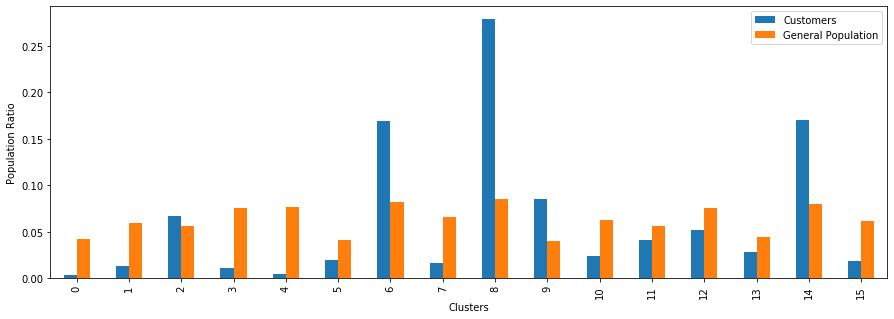

In [114]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_list = []
pop_list = []


for n in range(n_clusters):
    cust_list.append((pred_customers == n).sum()/len(pred_customers))
    pop_list.append((pred_population == n).sum()/len(pred_population))
                           
df_data = pd.DataFrame({"Clusters" : list(range(n_clusters)) , "Customers" : cust_list , "General Population":pop_list })

df_data.plot(x= 'Clusters', y = ["Customers", "General Population"], kind = "bar", figsize = (15,5))
plt.ylabel('Population Ratio')
plt.show

Text(0.5, 1.0, 'Customer vs General polulation Cluster difference')

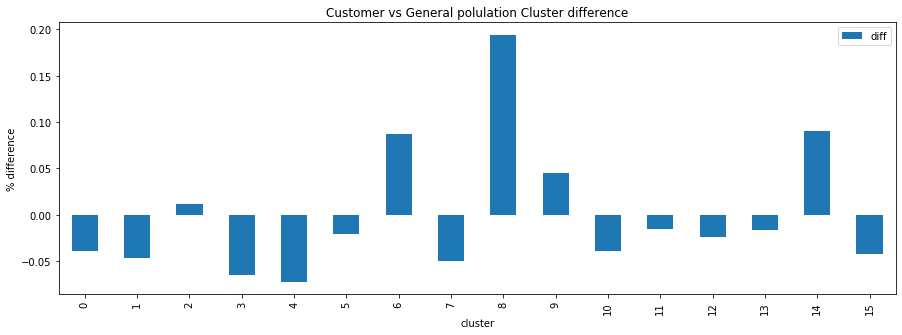

In [115]:
# Customer vs General polulation Cluster difference
df_data['diff']=df_data['Customers']-df_data['General Population']

df_data.plot(x= 'Clusters', y = 'diff', kind = "bar", figsize = (15,5))

plt.ylabel('% difference')
plt.xlabel('cluster')
plt.title('Customer vs General polulation Cluster difference')

In [116]:
df_data.sort_values('diff')

,Clusters,Customers,General Population,diff
4,4,0.004343,0.076269,-0.071926
3,3,0.010950,0.075740,-0.064790
7,7,0.015971,0.065380,-0.049409
1,1,0.012559,0.058915,-0.046356
15,15,0.018854,0.061032,-0.042178
10,10,0.023695,0.062562,-0.038866
0,0,0.002875,0.041642,-0.038767
12,12,0.051585,0.075379,-0.023794
5,5,0.019695,0.040561,-0.020866
13,13,0.028254,0.044732,-0.016477


Target class are 4, 6, and 15, and non target cluster are 2 and 14

In [117]:
transformer =  cluster_pipeline.named_steps['transform']
pca_components = cluster_pipeline.named_steps['pca']
kmeans = cluster_pipeline.named_steps['kmeans']

cluster_centers = pca_components.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=col_names)

num_scale = transformer.named_transformers_['num'].named_steps['num_scale']
log_scale = transformer.named_transformers_['log'].named_steps['log_scale']
log_transform = transformer.named_transformers_['log'].named_steps['log_transform']

cluster_centers_df[ordinal_categorical_cols] = num_scale.inverse_transform(cluster_centers_df[ordinal_categorical_cols])
cluster_centers_df[log_transform_cols] = log_scale.inverse_transform(cluster_centers_df[log_transform_cols])
cluster_centers_df[log_transform_cols] = log_transform.inverse_transform(cluster_centers_df[log_transform_cols])


In [118]:
cluster_centers_df 

,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,ALTERSKATEGORIE_GROB,CAMEO_DEUG_2015,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_INTL_2015_FAM_STAT_1,CAMEO_INTL_2015_FAM_STAT_2,CAMEO_INTL_2015_FAM_STAT_3,CAMEO_INTL_2015_FAM_STAT_4,CAMEO_INTL_2015_FAM_STAT_5
0,9.923434,415.362437,1993.103555,1.957480,7.651576,4.317906,4.256684,4.234887,1.794966,4.101687,...,0.023413,0.125280,0.431631,0.294534,0.094258,0.539357,0.049839,0.062860,0.186202,0.153439
1,13.975063,333.616649,1992.297912,2.368726,8.192819,5.975549,3.143898,3.928694,1.908244,3.757284,...,0.002666,0.287211,0.314887,0.226771,0.147471,0.843138,0.055505,0.023374,0.057206,0.017846
2,11.762742,446.474450,1992.168040,3.442483,7.335615,5.351550,1.732878,3.998860,2.849833,1.858101,...,-0.005314,0.659678,0.137196,0.038220,0.145809,0.477724,0.071105,0.057851,0.198520,0.193029
3,3.434874,686.629175,1992.733870,1.888263,4.475913,3.851062,4.105456,3.082987,2.062539,3.965309,...,0.073969,0.029609,0.471098,0.227877,0.062517,0.171842,0.119346,0.177056,0.393457,0.136008
4,9.156654,525.734043,1992.225499,1.893438,7.674324,4.949602,3.960277,3.736059,1.553682,4.405099,...,0.009596,0.072100,0.496878,0.279225,0.103012,0.551661,0.109902,0.124338,0.163444,0.047809
5,9.823284,437.406357,1993.063890,3.605007,7.284238,4.265015,2.307984,4.548063,2.893040,1.546311,...,0.003962,0.753712,0.083070,0.045171,0.126956,0.325798,0.009776,0.044260,0.207724,0.404767
6,1.575452,636.196399,1993.101676,3.531629,3.852097,1.774374,2.353712,2.223495,4.454725,1.599237,...,0.036274,0.467380,0.193473,-0.034887,0.042654,0.093339,0.208406,0.254282,0.330063,0.107375
7,3.252220,680.658521,1992.745261,1.770438,4.633618,3.697839,3.620320,2.512455,2.819235,4.028999,...,0.044892,0.039347,0.314902,0.221685,0.043325,0.193972,0.119500,0.178360,0.372125,0.133110
8,1.673257,638.763005,1992.663024,3.446447,3.317905,4.007970,1.693304,2.410538,4.441594,1.475593,...,0.090057,0.440835,0.126764,-0.039144,0.041124,0.044403,0.095501,0.175688,0.469242,0.212532
9,3.648483,539.802737,1992.365610,2.969110,3.831216,4.923640,1.980065,3.028995,3.400005,2.263627,...,0.082959,0.367882,0.160371,0.050742,0.087371,0.119524,0.010055,0.128512,0.492563,0.246720


Target clusters 4 & 6, non target clusters 2 & 14

In [143]:
comparison=cluster_centers_df.iloc[[8,14,4,3]].transpose()[cluster_centers_df.iloc[[8,14,4,3]].transpose().std(axis=1)>0.5]

In [144]:
comparison.loc['FINANZ_SPARER']

8     1.475593
14    1.555129
4     4.405099
3     3.965309
Name: FINANZ_SPARER, dtype: float64

In [121]:
comparison.index

Index(['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ALTERSKATEGORIE_GROB',
       'CAMEO_DEUG_2015', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_VORSORGER', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ANHANG',
       'KBA05_ANTG1', 'KBA05_ANTG3', 'KBA05_AUTOQUOT', 'KBA05_GBZ',
       'KBA05_KRSAQUOT', 'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61',
       'KBA13_AUTOQUOTE', 'KBA13_CCM_0_1400', 'KBA13_HALTER_50',
       'KBA13_HALTER_55', 'KBA13_HALTER_66', 'KONSUMNAEHE', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'ORTSGR_KLS9', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'RELAT_AB',
       'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_MAT',
       'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_TRADV',
       'WOHNDAUER_2008', 'AKT_DAT_KL', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT',
       'CAMEO_INTL_2015_FAM_STAT', 'CAMEO_INTL_2015_WEALTH

In [145]:
comparison.loc['FINANZ_MINIMALIST']

8     4.441594
14    4.365782
4     1.553682
3     2.062539
Name: FINANZ_MINIMALIST, dtype: float64

In [123]:
azdias_few['cluster']=pred_population

In [124]:
customers_few['cluster']=pred_customers

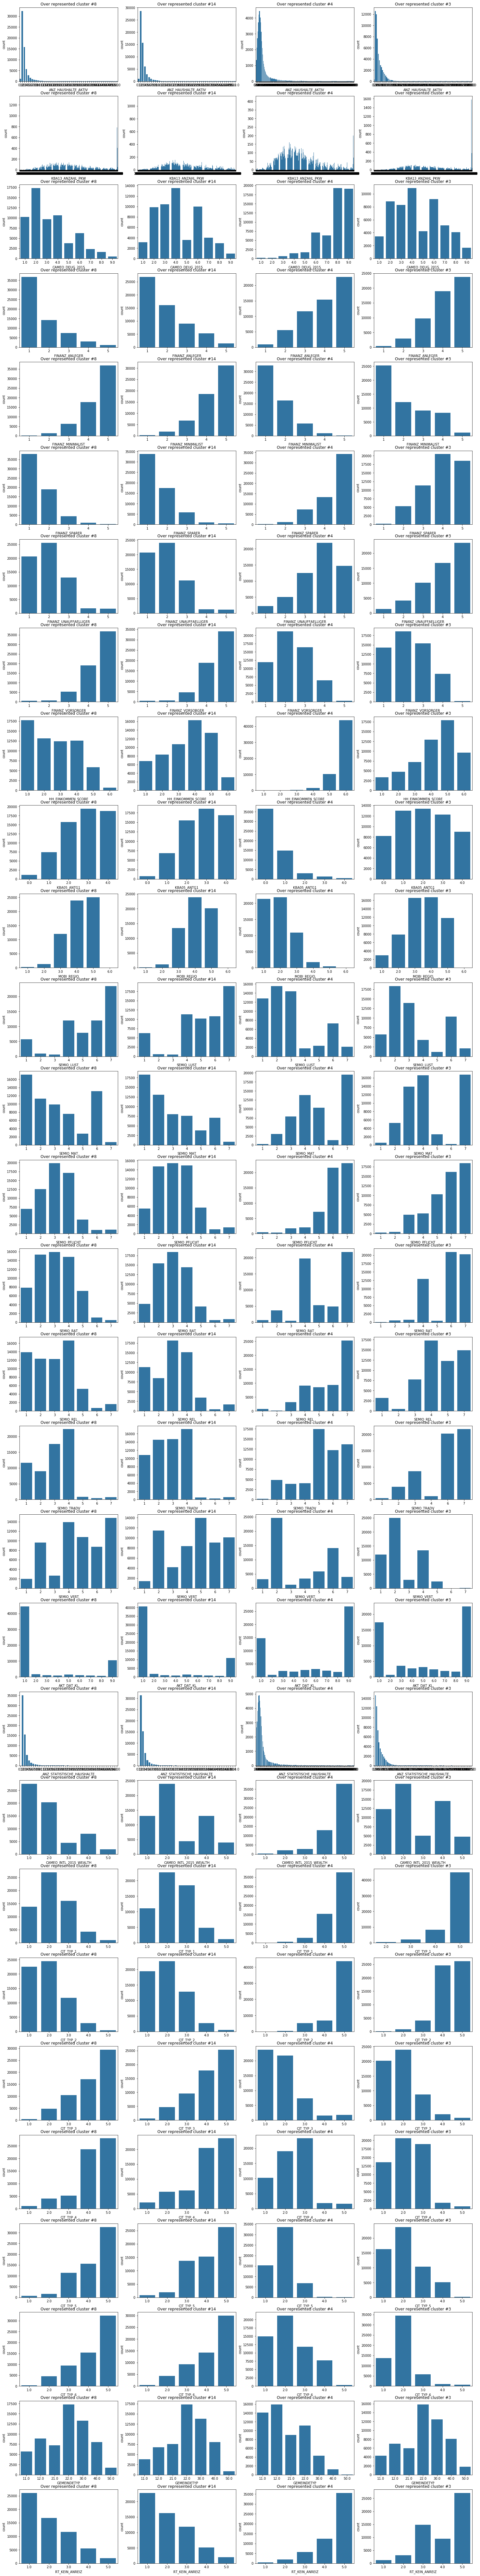

In [146]:
cumparison_population_customers=cluster_centers_df.iloc[[8,14,4,3]].transpose()[
    cluster_centers_df.iloc[[8,14,4,3]].transpose().std(axis=1)>1]
n_rows=len(cumparison_population_customers.index)


fig, axes = plt.subplots(nrows=n_rows, ncols=4, figsize=(25,5*n_rows))
count=0
for i in cumparison_population_customers.index:
    sb.countplot(azdias_few[azdias_few['cluster']==8][i], ax=axes[count,0] , color=base_color)
    axes[count,0].set_title('Over represented cluster #{}'.format(8))
    sb.countplot(azdias_few[azdias_few['cluster']==14][i], ax=axes[count,1] , color=base_color)
    axes[count,1].set_title('Over represented cluster #{}'.format(14))
    
    sb.countplot(azdias_few[azdias_few['cluster']==4][i], ax=axes[count,2] , color=base_color)
    axes[count,2].set_title('Over represented cluster #{}'.format(4))
    sb.countplot(azdias_few[azdias_few['cluster']==3][i], ax=axes[count,3] , color=base_color)
    axes[count,3].set_title('Over represented cluster #{}'.format(3))
    count=count+1

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [126]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train=mailout_train.drop('Unnamed: 0', axis=1)

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [127]:
mailout_train.shape

(42962, 367)

In [128]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [129]:
mailout_train_few, mailout_train, original_columns_mailout_train=clean_data(mailout_train, feature_unknown, feature_desc, cols_to_remove)

Unknown values replaced with NaN
Column name:  KBA05_MODTEMP
Values in population df:  [3, 4, 1, 2, 5, 6]
Values in feature description:  ['-1, 9', 1, 2, 3, 4, 5]
Column name:  LP_FAMILIE_FEIN
Values in population df:  [1, 10, 0, 2, 11, 8, 9, 7, 5, 4, 6, 3]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Column name:  LP_FAMILIE_GROB
Values in population df:  [5, 1, 0, 2, 4, 3]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Column name:  LP_LEBENSPHASE_FEIN
Values in population df:  [0, 6, 40, 8, 38, 13, 12, 20, 31, 32, 19, 15, 36, 16, 39, 37, 5, 9, 17, 35, 11, 7, 28, 30, 34, 27, 33, 29, 23, 10, 25, 1, 2, 26, 24, 14, 21, 4, 3, 22, 18]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Column name:  LP_LEBENSPHASE_GROB
Values in population df:  [12, 0, 2, 3, 5, 10, 4, 11, 8, 9, 1, 6, 7]
Values in feature description

In [130]:
mailout_train_few.shape

(42962, 276)

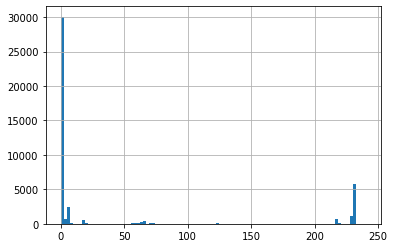

In [131]:
mailout_train.isna().sum(axis=1).hist(bins=100)

In [132]:
np.setdiff1d(mailout_train_few.columns, azdias_few.columns)

array(['RESPONSE'], dtype=object)

In [133]:
y=mailout_train_few['RESPONSE']
X=mailout_train_few.drop('RESPONSE', axis=1)

In [134]:
mailout_train.columns

Index(['AKT_DAT_KL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015',
       'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
       ...
       'VHN', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP',
       'RESPONSE', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB',
       'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_FAM_STAT'],
      dtype='object', length=276)

In [135]:
# still have to perform columns transformation of dataframe X

In [136]:
X.columns

Index(['AKT_DAT_KL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015',
       'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
       ...
       'VERS_TYP', 'VHN', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE',
       'ZABEOTYP', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB',
       'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_FAM_STAT'],
      dtype='object', length=275)

In [137]:
mailout_train['RESPONSE'].value_counts()/mailout_train.shape[0]*100

0    98.761696
1     1.238304
Name: RESPONSE, dtype: float64

We only have 1.2% of positive responses. Thus as we have imbalanced class, accuracy is not the best metrics to be used. In this case we will use AUC_ROC curve. 

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import learning_curve

pipeline1 = Pipeline([
                        ('transform', preprocessor), 
                        ('classifier', LogisticRegression(random_state=42))
                        ])
pipeline2 = Pipeline([
                        ('transform', preprocessor), 
                        ('classifier', RandomForestClassifier(random_state=42))
                        ])

pipeline3 = Pipeline([
                        ('transform', preprocessor), 
                        ('classifier', AdaBoostClassifier(random_state=42) )
                        ])

pipeline4 = Pipeline([
                        ('transform', preprocessor), 
                        ('classifier', GradientBoostingClassifier(random_state=42))
                        ])



Create plotting learning curve using https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [147]:
def plot_learning_curve(estimator, title, X, y, axes=None):
    
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=None, scoring='roc_auc',
                       train_sizes=np.linspace(.1, 1.0, 10))
    
    #cv=None - Determines the cross-validation splitting strategy. 
    #cv=None, to use the default 5-fold cross validation
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    print (title)
    print ("Roc_auc train score = {}".format(train_scores_mean[-1].round(2)))
    print ("Roc_auc validation score = {}".format(test_scores_mean[-1].round(2)))
    
    if axes == None:
        plt.figure()
    else:
        plt.axes = axes
    
    # Plot learning curve
    plt.grid()
    
    plt.plot(np.linspace(.1, 1.0, 10), train_scores_mean, 'o-', color='g',
                 label="Training score")
    plt.plot(np.linspace(.1, 1.0, 10), test_scores_mean, 'o-', color=base_color,
                 label="Cross-validation score")
    plt.legend(loc="best")
    plt.ylabel("Score")
    plt.title(title)

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anac

LogisticRegression
Roc_auc train score = 0.8
Roc_auc validation score = 0.63


C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20

RandomForestClassifier
Roc_auc train score = 0.99
Roc_auc validation score = 0.51


C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


AdaBoostClassifier
Roc_auc train score = 0.79
Roc_auc validation score = 0.65


C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GradientBoostingClassifier
Roc_auc train score = 0.91
Roc_auc validation score = 0.67


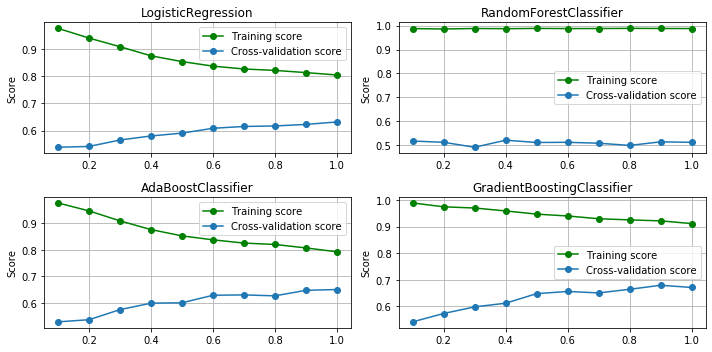

In [148]:
do_it=True
if do_it==True:
    plt.figure(figsize=(10, 5))

    # LogisticRegression
    ax1 = plt.subplot(2,2,1)
    plot_learning_curve(pipeline1, 'LogisticRegression', X, y, axes=ax1)

    # RandomForestClassifier
    ax2 = plt.subplot(2,2,2)
    plot_learning_curve(pipeline2, 'RandomForestClassifier', X, y, axes=ax2)

    #　AdaBoostClassifier
    ax3 = plt.subplot(2,2,3)
    plot_learning_curve(pipeline3, 'AdaBoostClassifier', X, y, axes=ax3)

    # GradientBoostingClassifier
    ax4 = plt.subplot(2,2,4)
    plot_learning_curve(pipeline4, 'GradientBoostingClassifier', X, y, axes=ax4)

    plt.tight_layout()
    plt.show()

### GridSearch

In [149]:
do_grid=True

if do_grid==True:
    from sklearn.model_selection import GridSearchCV

    gb=Pipeline([('transform', preprocessor), 
            ('classifier', GradientBoostingClassifier(random_state=42))
            ])

    parameters = {'classifier__learning_rate': [0.1, 0.2],
              'classifier__n_estimators': [100], 
              'classifier__max_depth': [3, 5], 
              'classifier__min_samples_split': [2, 4]
             }
        
    clf = GridSearchCV(gb,  param_grid=parameters, scoring = 'roc_auc')

    clf.fit(X, y)

    print (clf.best_params_)
    best_clf =clf.best_estimator_

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


In [150]:
from sklearn.metrics import roc_auc_score
best_predictions = best_clf.predict_proba(X)[:, 1]
# Make predictions using unoptimized and the best model
predictions = (gb.fit(X, y)).predict_proba(X)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y, predictions)))
print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(y, best_predictions)))

Roc_auc score on training data: 0.8729
Final Roc_auc score on the training data: 0.8729


In [151]:
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)
#obtain dummies column names
pl = preprocessor.named_transformers_['cat']
cd = pl.named_steps['encoder']
dummies_names1 = list(cd.get_feature_names())
col_names1=log_transform_cols+ ordinal_categorical_cols+binary_cols+dummies_names1

In [152]:
import pickle
# save the best model
filename = 'best_classifier.pkl'
outfile = open(filename, 'wb')
pickle.dump(best_clf , outfile)
outfile.close()

Text(0.5, 0, 'feature importance')

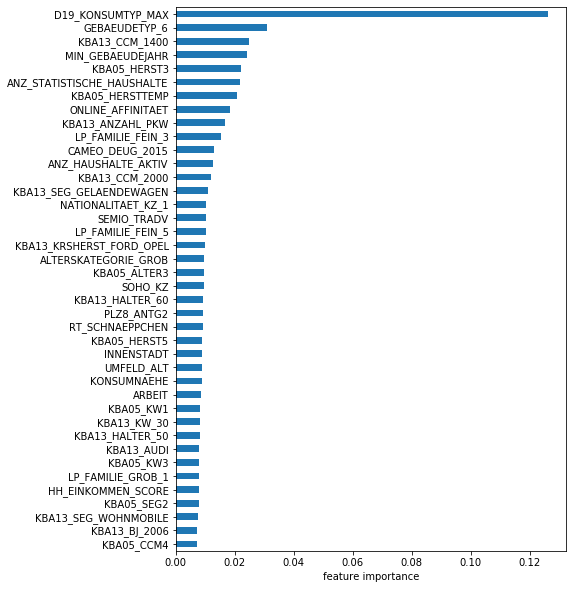

In [153]:
feature_importances = best_clf.named_steps['classifier'].feature_importances_
pd.Series(feature_importances, index=col_names1).sort_values()[-40:].plot(kind='barh', figsize=(7,10))
plt.xlabel('feature importance')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [182]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test=mailout_test.drop('Unnamed: 0', axis=1)

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [183]:
LNR_column=mailout_test['LNR']
LNR_column

0         1754
1         1770
2         1465
3         1470
4         1478
         ...  
42828    67615
42829    67938
42830    67942
42831    67949
42832    68898
Name: LNR, Length: 42833, dtype: int64

In [184]:
mailout_test_few, mailout_test, original_columns_mailout_test=clean_data(mailout_test, feature_unknown, feature_desc, cols_to_remove)

Unknown values replaced with NaN
Column name:  KBA05_MODTEMP
Values in population df:  [3, 4, 1, 2, 5, 6]
Values in feature description:  ['-1, 9', 1, 2, 3, 4, 5]
Column name:  LP_FAMILIE_FEIN
Values in population df:  [1, 10, 0, 2, 11, 9, 8, 7, 5, 4, 6, 3]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Column name:  LP_FAMILIE_GROB
Values in population df:  [5, 1, 0, 2, 4, 3]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Column name:  LP_LEBENSPHASE_FEIN
Values in population df:  [0, 6, 40, 8, 38, 12, 13, 20, 31, 32, 19, 15, 36, 39, 16, 37, 9, 5, 17, 35, 11, 7, 28, 34, 30, 27, 33, 29, 23, 10, 25, 1, 26, 2, 24, 14, 21, 22, 3, 18, 4]
Values in feature description:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Column name:  LP_LEBENSPHASE_GROB
Values in population df:  [12, 0, 2, 3, 5, 10, 4, 11, 8, 9, 1, 6, 7]
Values in feature description

In [185]:
mailout_train.columns.drop('RESPONSE')==mailout_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [186]:
#predict target values
kaggle_predict = best_clf.predict_proba(mailout_test)[:,1]
kaggle_predict

array([0.02263311, 0.02896272, 0.00261544, ..., 0.00798847, 0.00735916,
       0.01728742])

In [187]:
len(LNR_column)

42833

In [188]:
len(kaggle_predict)

42833

In [189]:
submission_df=pd.DataFrame(list([LNR_column, kaggle_predict])).transpose()

In [190]:
submission_df.rename(columns={'Unnamed 0':'RESPONSE'}, inplace=True)

In [191]:
submission_df

,LNR,RESPONSE
0,1754.0,0.022633
1,1770.0,0.028963
2,1465.0,0.002615
3,1470.0,0.004314
4,1478.0,0.003518
...,...,...
42828,67615.0,0.012325
42829,67938.0,0.013293
42830,67942.0,0.007988
42831,67949.0,0.007359


In [194]:
submission_df.to_csv('Arvato_Capstone_Submission.csv', index=False)